# L15b: Combining S5 and Spike Nueral Networks
Fill me in.


### Tasks
Before we start, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!
* __Task 1: Setup, Data, Prerequisites (10 min)__: In this task, we set up the computational environment and then specify a simple text sequence, e.g., a sentence without punctuation. From this sequence, we'll build a vocabulary, an inverse vocabulary, and the training datasets for the CBOW and skip-gram models. 
* __Task 2: Build and Train a CBOW model instance (20 min)__: In this task, we build and train a Continuous Bag of Words (CBOW) model instance on a sample input sequence. We start by creating a model instance, and then we train this instance for a few epochs, and finally, we see how the model performs.
* __Task 3: Build and train a skip-gram model instance (20 min)__: In this task, we will build and train a skip-gram model instance on the sample input sequence we selected above. We start by creating a model instance, then train it for a few epochs and see how it performs.

Let's get started!

___

## Task 1: Setup, Data, Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [1]:
include("Include.jl");

In [2]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end]; # helper function to get the file extension

### Load the MNIST digits data set
In this example, we'll use a Hopfield network to learn a single image pattern from [the MNIST handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database). The goal is to train the network to recognize a digit, e.g., "3" or "5", etc, and then retrieve it from a noisy input.

Load a training image dataset that we'll encode into the Hopfield network. We'll save training data in the `training_image_dataset` variable.
* _What's in the training dataset_? The `training_image_dataset` will be of type `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` where the first element is the input data `x.` The second element is the `label,` i.e., whether the image corresponds to `0,....,9`. However, the label is encoded as a `OneHotVector` (see below).
* _Hmmm. That's strange_. The `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` type has a couple of _weird features_. First, notice that the floating point is `Float32`, not the default `Float64`. Next, the labels are [One Hot ecoded](https://en.wikipedia.org/wiki/One-hot). Finally, the input data `x` is a Vector, not a Matrix (even though the original image is a matrix of `Gray` values).

However, before we load the training data, let's set some constants, which we use below. The comment next to each constant describes it, its permissible values, units, etc.

In [3]:
number_of_training_examples = 30; # how many training examples of *each* number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
number_of_images_to_memorize = 3; # number of images that we want to encode

`Unhide` the code blocks below to see how we construct and populate the `training_image_dataset` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},3}}`, and then we'll convert these to a vector format below.

In [4]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
    for i ∈ number_digit_array
        
        # create a set for this digit -
        image_digit_array = Array{Gray{N0f8},3}(undef, number_of_rows, number_of_cols, number_of_training_examples);
        files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
        imagecount = 1;
        for fileindex ∈ 1:number_of_training_examples
            filename = files[fileindex];
            ext = file_extension(filename)
            if (ext == "jpg")
                image_digit_array[:,:,fileindex] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
                imagecount += 1
            end
        end
    
        # capture -
        training_image_dictionary[i] = image_digit_array
    end
    training_image_dictionary
end;

Next, we take the images in array format and vectorize them. 
* _What do we mean by vectorize_? Each $N\times{N}$ image array containing the grayscale values at each pixel is converted to an $N^{2}$ vector of values. What image class, i.e., what number it represents, is then converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). The converted data is stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.
* _What's the deal with Float32_? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/), which has different memory constraints.

In [5]:
training_image_dataset = let
    training_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array);
        X = training_image_dictionary[i];
        
        for t ∈ 1:number_of_training_examples
            D = Array{Float32,1}(undef, number_of_pixels);
            linearindex = 1;
            for row ∈ 1:number_of_rows
                for col ∈ 1:number_of_cols
                    D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                    linearindex+=1;
                end
            end
    
            training_tuple = (D,Y);
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset
end;

## Task 2: What is a Spiking Neural Network?
Fill me in.

In [6]:
number_of_samples = length(training_image_dataset); # how many samples do we have?
number_of_neurons = 2^4; # how many SSN neurons do we want?
number_of_inputs = number_of_pixels; # how many inputs do we have?
ν = 0.1; # Table 2: firing threshold https://arxiv.org/abs/2205.11276
τ = 20.0; # Table 2: time constant (ms) https://arxiv.org/abs/2205.11276
Δt = 1.0; # samping time step (ms)
T = 100; # number of time steps of length Δt (ms) to simulate

Fill me in

In [7]:
Z = let

    # initialize -
    Z = Array{Int64,2}(undef, number_of_inputs, T);

    for i ∈ 1:T
        z = training_image_dataset[i][1] |> x-> round.(Int, x);
        Z[:,i] = z;
    end
    Z 
end

784×100 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0    

Fill me in

In [8]:
ssnmodel = let

    # build model -
    model = build(MyLIFSpikingNeuralNetworkModel, (
        Δt = Δt, # time step (ms)
        τ = τ, # time constant (ms)
        ν = ν, # firing threshold
        number_of_nodes = number_of_neurons, # number of neurons
        number_of_inputs = number_of_inputs, # number of inputs
    ));

    model;
end;

In [9]:
ssnmodel.W

16×784 Matrix{Float64}:
 0.00761975   0.00109544   0.00718645  …  0.00753035   0.00932271
 0.00410645   0.00349635   0.00832477     0.000276435  0.00610185
 0.000358585  0.00181873   0.00663482     0.000577974  0.00373933
 0.00450219   0.00955658   0.00304328     0.000104055  0.000551121
 0.0033983    0.00911722   0.00487994     0.00307079   0.00646643
 0.00771959   0.000632358  0.0047983   …  0.00421366   0.000386089
 0.00432014   0.00241648   0.00189644     0.00765977   0.00947486
 0.00607057   0.00649259   0.00155297     0.00327808   0.00794492
 0.00925484   0.00308511   0.00435991     0.0033368    0.00303534
 0.00126246   0.0039595    0.00739277     0.00953066   0.00211681
 0.00319607   0.00989838   0.00271135  …  0.00692047   0.00455918
 0.000535357  0.00826859   0.00675585     0.00798963   0.00194317
 0.0001552    0.00116658   0.00579737     0.000753234  0.00859037
 0.00876119   0.000692185  0.00861963     0.00811555   0.00276812
 0.0011787    0.00465909   0.00669592     0.008416

Fill me in

In [10]:
Z

784×100 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0    

In [11]:
(T,V,s) = solve(ssnmodel, Z, 100, Δ = 3);

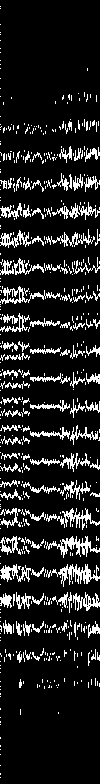

In [12]:
Gray.(Z)

Fill me in

In [ ]:
s .|> x-> NNlib.tanh_fast(x)

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.761594155955765
 0.0
 0.0
 0.0
 0.0
 0.761594155955765
 0.0
 0.761594155955765

In [14]:
s[2:end,:]

100×16 Matrix{Float64}:
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0     1.0  0.0  1.0  1.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0     1.0  0.0  1.0  1.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  1.0
 ⋮                        ⋮              ⋱       ⋮                        ⋮
 0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  1.0  1.0  1.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

## Task 3: Let's build an S5 model 
Fill me in.

In [35]:
s5model = let

    # initialize -
    number_of_hidden_states = 2^4; # number of hidden states
    number_of_inputs = number_of_neurons; # number of inputs
    number_of_outputs = 10; # the number of numbers we want to classify
    Δt = 20.0; # we'll use the same time step as before

    # build model -
    model = build(MyS5Model, (
        Δt = Δt, # time step (ms)
        number_of_hidden_states = number_of_hidden_states, # number of hidden states
        number_of_inputs = number_of_inputs, # number of inputs
        number_of_outputs = number_of_outputs, # the number of outputs
    ));

    model;
end;

inv(V) = [-0.1056495988790453 -0.1359045209269539 -0.16023049340630036 -0.18103818411210618 -0.1994359954916472 -0.2160441968458639 -0.23125210797244647 -0.245323442463715 -0.25844685307264986 -0.27076296179749915 -0.2823800123795764 -0.29338350618643244 -0.3038424297195292 -0.3138134420405497 -0.3233437847671782 -0.33247336146373985; -0.9883977122433221 0.10387600067591617 0.059050330228393566 0.04406339506328711 0.03630184705933096 0.03145076607466633 0.028081410549615164 0.025577811391485232 0.023628384225049516 0.02205749595047059 0.020758062889794576 0.019660785478429095 0.018718665014288035 0.017898599105321794 0.017176535249168075 0.016534534412833087; -0.07957952023335717 -0.9741790560904617 0.1540523906740287 0.08186866439778037 0.059105381427705536 0.04770292034404788 0.04074545148964759 0.03600247378202859 0.032530907987555674 0.02986125998845835 0.02773248115077614 0.025987306154191616 0.024525038723210327 0.0232780369089181 0.022199068841893353 0.021254084176964148; 0.0455

Fill me in

In [36]:
(TS5,HS5,YS5, U) = let
    
    U = s |> s-> transpose(s) |> Matrix .|> x-> tanh_fast(x);
    (TS5,HS5,YS5) = solve(s5model,U,100);

    TS5, HS5, YS5, U
end;

size(H) = (100, 16)


In [37]:
U

16×101 Matrix{Float64}:
 0.0  0.0       0.0       0.761594  0.0       …  0.0       0.0       0.0
 0.0  0.0       0.0       0.0       0.761594     0.0       0.0       0.0
 0.0  0.0       0.0       0.761594  0.0          0.0       0.0       0.761594
 0.0  0.0       0.0       0.761594  0.0          0.0       0.0       0.761594
 0.0  0.761594  0.0       0.0       0.0          0.0       0.0       0.761594
 0.0  0.761594  0.0       0.0       0.0       …  0.0       0.0       0.0
 0.0  0.0       0.0       0.761594  0.0          0.761594  0.0       0.0
 0.0  0.0       0.0       0.761594  0.0          0.0       0.761594  0.0
 0.0  0.0       0.761594  0.0       0.0          0.761594  0.0       0.0
 0.0  0.0       0.0       0.761594  0.0          0.0       0.0       0.0
 0.0  0.0       0.0       0.0       0.761594  …  0.0       0.0       0.0
 0.0  0.0       0.0       0.761594  0.0          0.0       0.0       0.761594
 0.0  0.0       0.0       0.761594  0.0          0.0       0.0       0.761594
 0

In [38]:
diag(s5model.Ā)

16-element Vector{Float64}:
 -0.9992787431693497
 -1.2050696587350904
 -1.099113296124118
 -1.0654248121813241
 -1.0488530884587834
 -1.0389892526325795
 -1.0324429294403448
 -1.0277795113796488
 -1.0242874346747073
 -1.021573500316455
 -1.0194026135040308
 -1.0176254234150621
 -1.016142255284616
 -1.0148835619819165
 -1.013798119682867
 -1.0128425936270384